# Mask R-CNN Training and Inference
In this notebook we use Matterport's implementation of Mask R-CNN to train on a custom dataset, then use the trained weights to run inference on new images.

This is part of a tutorial posted at http://www.immersivelimit.com/tutorials/using-mask-r-cnn-on-custom-coco-like-dataset, so check there for more details.

### Not a beginner tutorial...
This is not intended to be a complete beginner tutorial.
- You should know how to clone a git repository from GitHub
- You should have a decent understanding of Python programming
- You should understand the basics of training deep neural networks. If you've never done it before, I wouldn't recommend starting here. Find a beginner deep learning tutorial/course and start there. There's lots of great free stuff on YouTube.

## **Download the Free Training Dataset First!
I've provided a free training dataset of cigarette butt images for use with this tutorial.
1. Download it from here: http://www.immersivelimit.com/datasets/cigarette-butts
2. Then extract the files and put it in the "../datasets" directory of this repo
3. The code below will be looking for "../datasets/cig_butts/train", "../datasets/cig_butts/val", and "../datasets/cig_butts/real_test"

In [1]:
import os
import sys
import json
import numpy as np
import time
from PIL import Image, ImageDraw

In [ ]:
import wandb

wandb.init(project="maskrcnn", entity="sciarrilli")

## Import Matterport's "mrcnn" libraries
1. I'm using a forked version of Matterport's Mask_RCNN git repo to make sure this code works, even if the main repo changes. As of July 29, 2018, there is a bug in Matterport's version that breaks loading an existing model that I've fixed in my version (and submitted a pull request to fix it in theirs).
  - My version is here: https://github.com/akTwelve/Mask_RCNN
  - The original is here: https://github.com/matterport/Mask_RCNN
2. Update the code cell below to point to the root directory of the repo on your machine.

In [2]:
# Set the ROOT_DIR variable to the root directory of the Mask_RCNN git repo
ROOT_DIR = '../../'
assert os.path.exists(ROOT_DIR), 'ROOT_DIR does not exist. Did you forget to read the instructions above? ;)'

# Import mrcnn libraries
sys.path.append(ROOT_DIR) 
from mrcnn.config import Config
import mrcnn.utils as utils
from mrcnn import visualize
import mrcnn.model as modellib


/home/ec2-user/anaconda3/envs/maskrcnn/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/ec2-user/anaconda3/envs/maskrcnn/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/ec2-user/anaconda3/envs/maskrcnn/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/ec2-user/anaconda3/envs/mask

## Set up logging and pre-trained model paths
This will default to sub-directories in your mask_rcnn_dir, but if you want them somewhere else, updated it here.

It will also download the pre-trained coco model.

In [3]:
# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs/bdd100k")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")

# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

## Configuration
Define configurations for training on the Cigarette Butt dataset.
### Note
These are settings that worked on my machine (GTX 970 graphics card). If you are getting OOM (Out of Memory) errors, you may need to tweak the settings or your computer may not be powerful enough. If you have a better graphics card, you will want to tweak it to take advantage of that.

In [4]:
class Bdd100kConfig(Config):
    """Configuration for training on the bdd100k segmentation dataset."""
    # Give the configuration a recognizable name
    NAME = "bdd100k"

    # Adjust depending on your GPU memory
    IMAGES_PER_GPU = 4

    # Number of classes (including background)
    NUM_CLASSES = 1 + 8  # Background + pedestrian, rider, car, truck, bus, train, motorcycle, bicycle

    # Number of training and validation steps per epoch
    STEPS_PER_EPOCH = 100
    VALIDATION_STEPS = 30

    # Don't exclude based on confidence. Since we have two classes
    # then 0.5 is the minimum anyway as it picks between nucleus and BG
    # DETECTION_MIN_CONFIDENCE = 0

    # Backbone network architecture
    # Supported values are: resnet50, resnet101
    BACKBONE = "resnet50"

    # Input image resizing
    # Random crops of size 512x512
    #IMAGE_RESIZE_MODE = "pad64"
    IMAGE_MIN_DIM = 720
    IMAGE_MAX_DIM = 1280
    # IMAGE_MIN_SCALE = 2.0

    # Length of square anchor side in pixels
    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)

    # ROIs kept after non-maximum supression (training and inference)
    POST_NMS_ROIS_TRAINING = 1000
    POST_NMS_ROIS_INFERENCE = 2000

    # Non-max suppression threshold to filter RPN proposals.
    # You can increase this during training to generate more propsals.
    RPN_NMS_THRESHOLD = 0.9

    # How many anchors per image to use for RPN training
    RPN_TRAIN_ANCHORS_PER_IMAGE = 64

    # Image mean (RGB)
    MEAN_PIXEL = np.array([43.53, 39.56, 48.22])

    # If enabled, resizes instance masks to a smaller size to reduce
    # memory load. Recommended when using high-resolution images.
    USE_MINI_MASK = True
    MINI_MASK_SHAPE = (56, 56)  # (height, width) of the mini-mask

    # Number of ROIs per image to feed to classifier/mask heads
    # The Mask RCNN paper uses 512 but often the RPN doesn't generate
    # enough positive proposals to fill this and keep a positive:negative
    # ratio of 1:3. You can increase the number of proposals by adjusting
    # the RPN NMS threshold.
    TRAIN_ROIS_PER_IMAGE = 128

    # Maximum number of ground truth instances to use in one image
    MAX_GT_INSTANCES = 200

    # Max number of final detections per image
    DETECTION_MAX_INSTANCES = 400
    
    # The magical learning rate
    #LEARNING_RATE = 0.01
    
config = Bdd100kConfig()
config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     4
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        400
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 4
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1280
IMAGE_META_SIZE                21
IMAGE_MIN_DIM                  720
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1280 1280    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE          

# Define the dataset
I've attempted to make this generic to any COCO-like dataset. That means if you have another dataset defined in the COCO format, it should work.

In [5]:
from pycocotools import mask
import cv2
from tqdm import tqdm

class Bdd100kDataset(utils.Dataset):

    def load_bdd100k(self, annotation_json, images_dir):
        """Load a subset of the bdd100k dataset.

        dataset_dir: Root directory of the dataset
        subset: Subset to load. Either the name of the sub-directory,
                such as stage1_train, stage1_test, ...etc. or, one of:
                * train: stage1_train excluding validation images
                * val: validation images from VAL_IMAGE_IDS
        """
        
        data = json.load(open(annotation_json))
        
        source_name = "bdd100k"
        for category in data['categories']:
            class_id = category['id']
            class_name = category['name']
            if class_id < 1:
                print('Error: Class id for "{}" cannot be less than one. (0 is reserved for the background)'.format(class_name))
                return
            
            self.add_class(source_name, class_id, class_name)


        # Add images
        annotations = {}
        for annotation in tqdm(data['annotations']):
            
            # Initialize variables
            image_id = annotation['image_id']
            segmentation = []

            # Decode the binary mask
            mask_list = mask.decode(annotation['segmentation'])
            mask_list = np.ascontiguousarray(mask_list, dtype=np.uint8)
            contours, hierarchy = cv2.findContours((mask_list).astype(np.uint8), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

            # Get the contours
            for contour in contours:
                contour = contour.flatten().tolist()
                segmentation.append(contour)
                if len(contour) > 4:
                    segmentation.append(contour)
            if len(segmentation) == 0:
                print('segmentation = 0')

            if image_id not in annotations:
                annotations[image_id] = []
            annotation['segmentation'] = segmentation
            annotation['iscrowd'] = 0
            annotations[image_id].append(annotation)
        
#         out_file = open("./annotations_val.json", "w")
#         json.dump(annotations, out_file, indent = 4)
#         out_file.close()
        
#         if split == 'train':
#             file = open('./annotations_train.json')
#             annotations = json.load(file)
#         elif split == 'val':
#             file = open('./annotations_val.json')
#             annotations = json.load(file)           

        #seen_images = {}
        images = []
        for image in tqdm(data['images']):
            image_id = image['id']

            try:
                image_file_name = image['file_name']
                image_width = 1280
                image_height = 720
                image_path = os.path.join(images_dir, image_file_name)
                image_annotations = annotations[image_id]
            except KeyError as key:
                print("Warning: Skipping image (id: {}) with missing key: {}".format(image_id, key))

            # Add the image using the base method from utils.Dataset
            self.add_image(
                source=source_name,
                image_id=image_id,
                path=image_path,
                width=image_width,
                height=image_height,
                annotations=image_annotations
            )

    def load_mask(self, image_id):
        """ Load instance masks for the given image.
        MaskRCNN expects masks in the form of a bitmap [height, width, instances].
        Args:
            image_id: The id of the image to load masks for
        Returns:
            masks: A bool array of shape [height, width, instance count] with
                one mask per instance.
            class_ids: a 1D array of class IDs of the instance masks.
        """
        image_info = self.image_info[image_id]
        annotations = image_info['annotations']
        instance_masks = []
        class_ids = []
        
        for annotation in annotations:
            class_id = annotation['category_id']
            mask = Image.new('1', (image_info['width'], image_info['height']))
            mask_draw = ImageDraw.ImageDraw(mask, '1')
            for segmentation in annotation['segmentation']:
                try:
                    mask_draw.polygon(segmentation, fill=1)
                    bool_array = np.array(mask) > 0
                    instance_masks.append(bool_array)
                    class_ids.append(class_id)
                except:
                    continue


        mask = np.dstack(instance_masks)
        class_ids = np.array(class_ids, dtype=np.int32)
        
        return mask, class_ids

    def image_reference(self, image_id):
        """Return the path of the image."""
        info = self.image_info[image_id]
        if info["source"] == "bdd100k":
            return info["id"]
        else:
            super(self.__class__, self).image_reference(image_id)

# Create the Training and Validation Datasets
Make sure you download the training dataset linked at the top of this notebook. If you put the dataset somewhere else, update the paths below.

In [6]:
dataset_train = Bdd100kDataset()
dataset_train.load_bdd100k('../../datasets/bdd100k/train/ins_seg_train_cocofmt.json', '../../datasets/bdd100k/train/')
dataset_train.prepare()

dataset_val = Bdd100kDataset()
dataset_val.load_bdd100k('../../datasets/bdd100k/val/ins_seg_val_cocofmt.json', '../../datasets/bdd100k/val')
dataset_val.prepare()

100%|██████████| 7000/7000 [00:00<00:00, 76861.39it/s]


100%|██████████| 1000/1000 [00:00<00:00, 56487.42it/s]

## Display a few images from the training dataset

6986


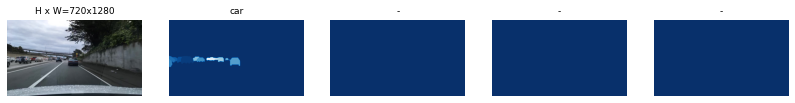

4309


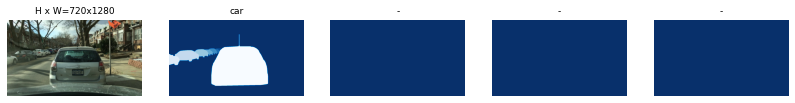

2776


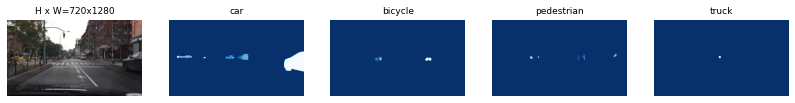

74


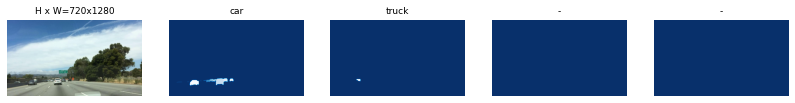

3413


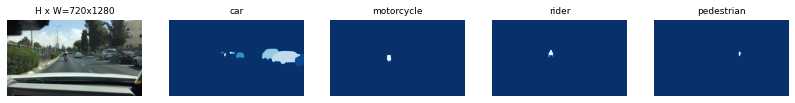

3303


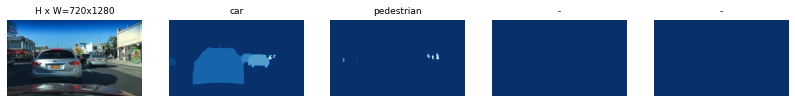

6472


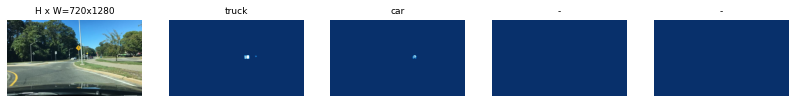

5734


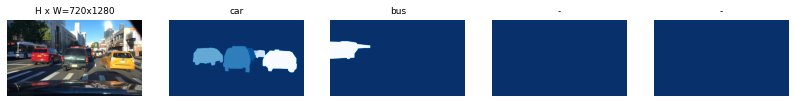

5669


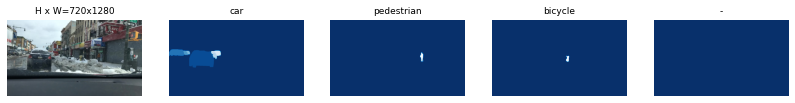

5813


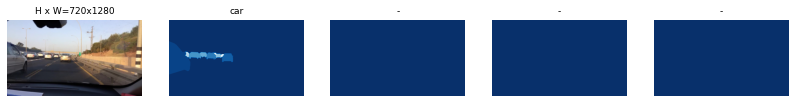

899


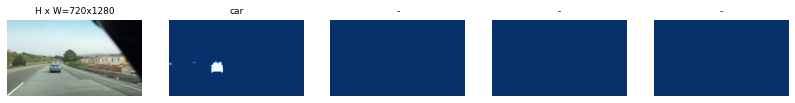

In [7]:
dataset = dataset_train
image_ids = np.random.choice(dataset.image_ids, 10)
image_ids = np.append(image_ids, 899)
for image_id in image_ids:
    print(image_id)
    image = dataset.load_image(image_id)
    mask, class_ids = dataset.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset.class_names)

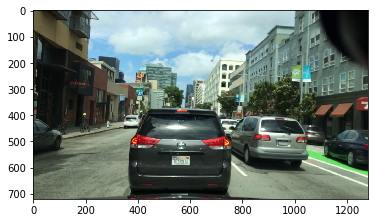

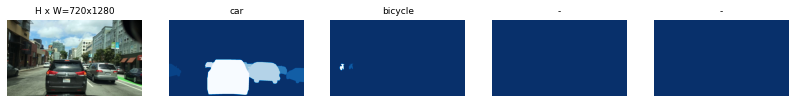

In [8]:
image = dataset.load_image(908)
mask, class_ids = dataset.load_mask(908)
from matplotlib import pyplot as plt
plt.imshow(image, interpolation='nearest')
plt.show()
visualize.display_top_masks(image, mask, class_ids, dataset.class_names)

# Create the Training Model and Train
This code is largely borrowed from the train_shapes.ipynb notebook.

In [9]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [10]:
# Which weights to start with?
init_with = "coco"  # imagenet, coco, or last
# init_with = "last"

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last(), by_name=True)

2022-03-07 20:11:53.150858: I tensorflow/core/platform/cpu_feature_guard.cc:141] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 AVX512F FMA
2022-03-07 20:11:53.183903: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2499995000 Hz
2022-03-07 20:11:53.188461: I tensorflow/compiler/xla/service/service.cc:150] XLA service 0x56288ae2e810 executing computations on platform Host. Devices:
2022-03-07 20:11:53.188481: I tensorflow/compiler/xla/service/service.cc:158]   StreamExecutor device (0): <undefined>, <undefined>
2022-03-07 20:11:55.371520: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-07 20:11:55.371529: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so r

## Training

Train in two stages:

1. Only the heads. Here we're freezing all the backbone layers and training only the randomly initialized layers (i.e. the ones that we didn't use pre-trained weights from MS COCO). To train only the head layers, pass layers='heads' to the train() function.

2. Fine-tune all layers. For this simple example it's not necessary, but we're including it to show the process. Simply pass layers="all to train all layers.



In [11]:
#pip install -U scikit-image==0.16.2

# import skimage
# print(skimage.__version__)

In [12]:
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
start_train = time.time()
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=4, 
            layers='heads')
end_train = time.time()
minutes = round((end_train - start_train) / 60, 2)
print(f'Training took {minutes} minutes')


Starting at epoch 0. LR=0.001

Checkpoint Path: ../../logs/bdd100k/bdd100k20220307T2011/mask_rcnn_bdd100k_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mask_bn4  

/home/ec2-user/anaconda3/envs/maskrcnn/lib/python3.7/site-packages/tensorflow/python/ops/gradients_impl.py:110: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/ec2-user/anaconda3/envs/maskrcnn/lib/python3.7/site-packages/keras/engine/training.py:2039: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 1/4


2022-03-07 20:12:39.823014: W ./tensorflow/core/grappler/optimizers/graph_optimizer_stage.h:241] Failed to run optimizer ArithmeticOptimizer, stage RemoveStackStridedSliceSameAxis node proposal_targets/strided_slice. Error: ValidateStridedSliceOp returned partial shapes [1,?,?] and [?,?]
2022-03-07 20:12:39.824532: W ./tensorflow/core/grappler/optimizers/graph_optimizer_stage.h:241] Failed to run optimizer ArithmeticOptimizer, stage RemoveStackStridedSliceSameAxis node proposal_targets/strided_slice_37. Error: ValidateStridedSliceOp returned partial shapes [1,?,?] and [?,?]
2022-03-07 20:12:39.824987: W ./tensorflow/core/grappler/optimizers/graph_optimizer_stage.h:241] Failed to run optimizer ArithmeticOptimizer, stage RemoveStackStridedSliceSameAxis node proposal_targets/strided_slice_74. Error: ValidateStridedSliceOp returned partial shapes [1,?,?] and [?,?]
2022-03-07 20:12:39.825231: W ./tensorflow/core/grappler/optimizers/graph_optimizer_stage.h:241] Failed to run optimizer Arithm

 99/100 [============================>.] - ETA: 1s - loss: 3.2380 - rpn_class_loss: 0.2133 - rpn_bbox_loss: 1.7651 - mrcnn_class_loss: 0.1986 - mrcnn_bbox_loss: 0.5589 - mrcnn_mask_loss: 0.5021

/home/ec2-user/anaconda3/envs/maskrcnn/lib/python3.7/site-packages/keras/engine/training.py:2197: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'
2022-03-07 20:15:25.569918: W ./tensorflow/core/grappler/optimizers/graph_optimizer_stage.h:241] Failed to run optimizer ArithmeticOptimizer, stage RemoveStackStridedSliceSameAxis node proposal_targets/strided_slice. Error: ValidateStridedSliceOp returned partial shapes [1,?,?] and [?,?]
2022-03-07 20:15:25.573719: W ./tensorflow/core/grappler/optimizers/graph_optimizer_stage.h:241] Failed to run optimizer ArithmeticOptimizer, stage RemoveStackStridedSliceSameAxis node proposal_targets/strided_slice_37. Error: ValidateStridedSliceOp returned partial shapes [1,?,?] and [?,?]
2022-03-07 20:15:25.574763: W ./tensorflow/core/grappler/optimizers/graph_optimizer_stage.h:

100/100 [==============================] - 243s 2s/step - loss: 3.2371 - rpn_class_loss: 0.2127 - rpn_bbox_loss: 1.7699 - mrcnn_class_loss: 0.1974 - mrcnn_bbox_loss: 0.5566 - mrcnn_mask_loss: 0.5004 - val_loss: 2.9945 - val_rpn_class_loss: 0.0762 - val_rpn_bbox_loss: 1.9292 - val_mrcnn_class_loss: 0.1972 - val_mrcnn_bbox_loss: 0.3946 - val_mrcnn_mask_loss: 0.3973
Epoch 2/4
100/100 [==============================] - 133s 1s/step - loss: 2.5309 - rpn_class_loss: 0.0758 - rpn_bbox_loss: 1.4364 - mrcnn_class_loss: 0.2469 - mrcnn_bbox_loss: 0.3866 - mrcnn_mask_loss: 0.3852 - val_loss: 2.5940 - val_rpn_class_loss: 0.0644 - val_rpn_bbox_loss: 1.5348 - val_mrcnn_class_loss: 0.2521 - val_mrcnn_bbox_loss: 0.3736 - val_mrcnn_mask_loss: 0.3690
Epoch 3/4
100/100 [==============================] - 136s 1s/step - loss: 2.6106 - rpn_class_loss: 0.0805 - rpn_bbox_loss: 1.5141 - mrcnn_class_loss: 0.2935 - mrcnn_bbox_loss: 0.3596 - mrcnn_mask_loss: 0.3629 - val_loss: 2.5595 - val_rpn_class_loss: 0.0878 -

In [13]:
# Fine tune all layers
# Passing layers="all" trains all layers. You can also 
# pass a regular expression to select which layers to
# train by name pattern.
start_train = time.time()
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE / 10,
            epochs=8, 
            layers="all")
end_train = time.time()
minutes = round((end_train - start_train) / 60, 2)
print(f'Training took {minutes} minutes')


Starting at epoch 4. LR=0.0001

Checkpoint Path: ../../logs/bdd100k/bdd100k20220307T2011/mask_rcnn_bdd100k_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b         (Conv2D)
bn3a_branch2b  

2022-03-07 20:24:13.745228: W ./tensorflow/core/grappler/optimizers/graph_optimizer_stage.h:241] Failed to run optimizer ArithmeticOptimizer, stage RemoveStackStridedSliceSameAxis node proposal_targets/strided_slice. Error: ValidateStridedSliceOp returned partial shapes [1,?,?] and [?,?]
2022-03-07 20:24:13.745296: W ./tensorflow/core/grappler/optimizers/graph_optimizer_stage.h:241] Failed to run optimizer ArithmeticOptimizer, stage RemoveStackStridedSliceSameAxis node proposal_targets/strided_slice_37. Error: ValidateStridedSliceOp returned partial shapes [1,?,?] and [?,?]
2022-03-07 20:24:13.745314: W ./tensorflow/core/grappler/optimizers/graph_optimizer_stage.h:241] Failed to run optimizer ArithmeticOptimizer, stage RemoveStackStridedSliceSameAxis node proposal_targets/strided_slice_74. Error: ValidateStridedSliceOp returned partial shapes [1,?,?] and [?,?]
2022-03-07 20:24:13.745329: W ./tensorflow/core/grappler/optimizers/graph_optimizer_stage.h:241] Failed to run optimizer Arithm

 99/100 [============================>.] - ETA: 1s - loss: 2.3730 - rpn_class_loss: 0.0759 - rpn_bbox_loss: 1.3102 - mrcnn_class_loss: 0.3250 - mrcnn_bbox_loss: 0.3176 - mrcnn_mask_loss: 0.3443

2022-03-07 20:26:50.714701: W ./tensorflow/core/grappler/optimizers/graph_optimizer_stage.h:241] Failed to run optimizer ArithmeticOptimizer, stage RemoveStackStridedSliceSameAxis node proposal_targets/strided_slice. Error: ValidateStridedSliceOp returned partial shapes [1,?,?] and [?,?]
2022-03-07 20:26:50.717890: W ./tensorflow/core/grappler/optimizers/graph_optimizer_stage.h:241] Failed to run optimizer ArithmeticOptimizer, stage RemoveStackStridedSliceSameAxis node proposal_targets/strided_slice_37. Error: ValidateStridedSliceOp returned partial shapes [1,?,?] and [?,?]
2022-03-07 20:26:50.718994: W ./tensorflow/core/grappler/optimizers/graph_optimizer_stage.h:241] Failed to run optimizer ArithmeticOptimizer, stage RemoveStackStridedSliceSameAxis node proposal_targets/strided_slice_74. Error: ValidateStridedSliceOp returned partial shapes [1,?,?] and [?,?]
2022-03-07 20:26:50.719677: W ./tensorflow/core/grappler/optimizers/graph_optimizer_stage.h:241] Failed to run optimizer Arithm

100/100 [==============================] - 224s 2s/step - loss: 2.3659 - rpn_class_loss: 0.0756 - rpn_bbox_loss: 1.3030 - mrcnn_class_loss: 0.3249 - mrcnn_bbox_loss: 0.3179 - mrcnn_mask_loss: 0.3446 - val_loss: 2.5547 - val_rpn_class_loss: 0.0693 - val_rpn_bbox_loss: 1.4678 - val_mrcnn_class_loss: 0.3604 - val_mrcnn_bbox_loss: 0.3103 - val_mrcnn_mask_loss: 0.3469
Epoch 6/8
100/100 [==============================] - 178s 2s/step - loss: 2.2047 - rpn_class_loss: 0.0629 - rpn_bbox_loss: 1.2132 - mrcnn_class_loss: 0.2996 - mrcnn_bbox_loss: 0.2983 - mrcnn_mask_loss: 0.3307 - val_loss: 2.2252 - val_rpn_class_loss: 0.0516 - val_rpn_bbox_loss: 1.3150 - val_mrcnn_class_loss: 0.2959 - val_mrcnn_bbox_loss: 0.2659 - val_mrcnn_mask_loss: 0.2967
Epoch 7/8
100/100 [==============================] - 180s 2s/step - loss: 2.1909 - rpn_class_loss: 0.0772 - rpn_bbox_loss: 1.1805 - mrcnn_class_loss: 0.3063 - mrcnn_bbox_loss: 0.2894 - mrcnn_mask_loss: 0.3375 - val_loss: 2.2883 - val_rpn_class_loss: 0.0578 -

# Prepare to run Inference
Create a new InferenceConfig, then use it to create a new model.

In [14]:
class InferenceConfig(Bdd100kConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    IMAGE_MIN_DIM = 720
    IMAGE_MAX_DIM = 1280
    DETECTION_MIN_CONFIDENCE = 0.75
    

inference_config = InferenceConfig()

In [15]:
# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

Instructions for updating:
Use tf.cast instead.


In [16]:
# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_path = model.find_last()

# Load trained weights (fill in path to trained weights here)
assert model_path != "", "Provide path to trained weights"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Loading weights from  ../../logs/bdd100k/bdd100k20220307T2011/mask_rcnn_bdd100k_0008.h5
Re-starting from epoch 8


# Run Inference
Run model.detect() on real images.

We get some false positives, and some misses. More training images are likely needed to improve the results.

Processing 1 images
image                    shape: (720, 1280, 3)        min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1280, 1280, 3)    min:  -48.22000  max:  215.44000  float64
image_metas              shape: (1, 21)               min:    0.00000  max: 1280.00000  int64
anchors                  shape: (1, 409200, 4)        min:   -0.07077  max:    1.02073  float32


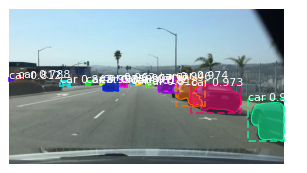

Processing 1 images
image                    shape: (720, 1280, 3)        min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1280, 1280, 3)    min:  -48.22000  max:  215.44000  float64
image_metas              shape: (1, 21)               min:    0.00000  max: 1280.00000  int64
anchors                  shape: (1, 409200, 4)        min:   -0.07077  max:    1.02073  float32


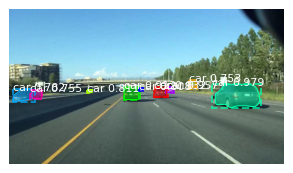

Processing 1 images
image                    shape: (720, 1280, 3)        min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1280, 1280, 3)    min:  -48.22000  max:  215.44000  float64
image_metas              shape: (1, 21)               min:    0.00000  max: 1280.00000  int64
anchors                  shape: (1, 409200, 4)        min:   -0.07077  max:    1.02073  float32


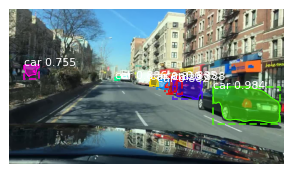

Processing 1 images
image                    shape: (720, 1280, 3)        min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1280, 1280, 3)    min:  -48.22000  max:  215.44000  float64
image_metas              shape: (1, 21)               min:    0.00000  max: 1280.00000  int64
anchors                  shape: (1, 409200, 4)        min:   -0.07077  max:    1.02073  float32


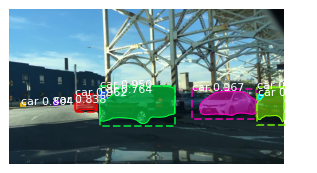

Processing 1 images
image                    shape: (720, 1280, 3)        min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1280, 1280, 3)    min:  -48.22000  max:  215.44000  float64
image_metas              shape: (1, 21)               min:    0.00000  max: 1280.00000  int64
anchors                  shape: (1, 409200, 4)        min:   -0.07077  max:    1.02073  float32


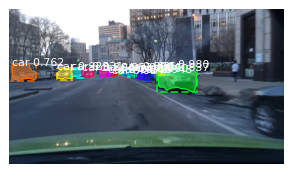

Processing 1 images
image                    shape: (720, 1280, 3)        min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1280, 1280, 3)    min:  -48.22000  max:  215.44000  float64
image_metas              shape: (1, 21)               min:    0.00000  max: 1280.00000  int64
anchors                  shape: (1, 409200, 4)        min:   -0.07077  max:    1.02073  float32


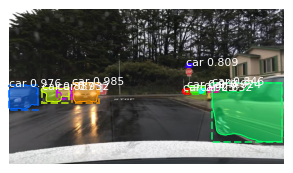

Processing 1 images
image                    shape: (720, 1280, 3)        min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1280, 1280, 3)    min:  -48.22000  max:  215.44000  float64
image_metas              shape: (1, 21)               min:    0.00000  max: 1280.00000  int64
anchors                  shape: (1, 409200, 4)        min:   -0.07077  max:    1.02073  float32


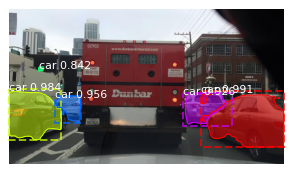

Processing 1 images
image                    shape: (720, 1280, 3)        min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1280, 1280, 3)    min:  -48.22000  max:  215.44000  float64
image_metas              shape: (1, 21)               min:    0.00000  max: 1280.00000  int64
anchors                  shape: (1, 409200, 4)        min:   -0.07077  max:    1.02073  float32


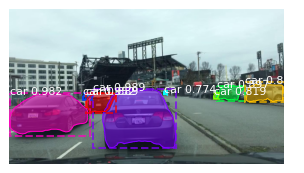

Processing 1 images
image                    shape: (720, 1280, 3)        min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1280, 1280, 3)    min:  -48.22000  max:  215.44000  float64
image_metas              shape: (1, 21)               min:    0.00000  max: 1280.00000  int64
anchors                  shape: (1, 409200, 4)        min:   -0.07077  max:    1.02073  float32


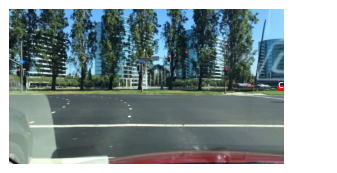

Processing 1 images
image                    shape: (720, 1280, 3)        min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1280, 1280, 3)    min:  -48.22000  max:  215.44000  float64
image_metas              shape: (1, 21)               min:    0.00000  max: 1280.00000  int64
anchors                  shape: (1, 409200, 4)        min:   -0.07077  max:    1.02073  float32


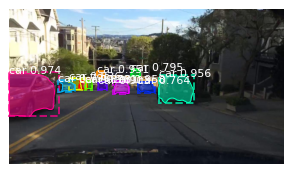

In [17]:
import skimage

real_test_dir = '../../datasets/bdd100k/test/'
image_paths = []
for filename in np.random.choice(os.listdir(real_test_dir), 10, replace=False):
    if os.path.splitext(filename)[1].lower() in ['.png', '.jpg', '.jpeg']:
        image_paths.append(os.path.join(real_test_dir, filename))

for image_path in image_paths:
    img = skimage.io.imread(image_path)
    img_arr = np.array(img)
    results = model.detect([img_arr], verbose=1)
    r = results[0]
    visualize.display_instances(img, r['rois'], r['masks'], r['class_ids'], 
                                dataset_val.class_names, r['scores'], figsize=(5,5))

# Didn't Work

In [18]:
# #
# #
# # WORK IN PROGRESS
# #
# #
# #


# from pycocotools import mask
# import cv2
# from tqdm import tqdm
# import json
# import numpy as np
# from pycocotools import mask
# from skimage import measure


# class Bdd100kDataset(utils.Dataset):

#     def load_bdd100k(self, annotation_json, images_dir):
#         """Load a subset of the bdd100k dataset.

#         dataset_dir: Root directory of the dataset
#         subset: Subset to load. Either the name of the sub-directory,
#                 such as stage1_train, stage1_test, ...etc. or, one of:
#                 * train: stage1_train excluding validation images
#                 * val: validation images from VAL_IMAGE_IDS
#         """
        
#         data = json.load(open(annotation_json))
        
#         source_name = "bdd100k"
#         for category in data['categories']:
#             class_id = category['id']
#             class_name = category['name']
#             if class_id < 1:
#                 print('Error: Class id for "{}" cannot be less than one. (0 is reserved for the background)'.format(class_name))
#                 return
            
#             self.add_class(source_name, class_id, class_name)


#         # Add images
#         annotations = {}
#         for annotation in tqdm(data['annotations'][:5000]):
            
#             # Initialize variables
#             image_id = annotation['image_id']
#             segmentation = []


#             ground_truth_binary_mask = mask.decode(annotation['segmentation'])
#             fortran_ground_truth_binary_mask = np.asfortranarray(ground_truth_binary_mask)
#             encoded_ground_truth = mask.encode(fortran_ground_truth_binary_mask)
#             ground_truth_area = mask.area(encoded_ground_truth)
#             ground_truth_bounding_box = mask.toBbox(encoded_ground_truth)
#             contours = measure.find_contours(ground_truth_binary_mask, 0.5)
            
#             # Decode the binary mask
# #             mask_list = mask.decode(annotation['segmentation'])
# #             mask_list = np.ascontiguousarray(mask_list, dtype=np.uint8)
# #             contours, hierarchy = cv2.findContours((mask_list).astype(np.uint8), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
# #             # Get the contours
# #             for contour in contours:
# #                 contour = contour.flatten().tolist()
# #                 segmentation.append(contour)
# #                 if len(contour) > 4:
# #                     segmentation.append(contour)
# #             if len(segmentation) == 0:
# #                 print('segmentation = 0')
            
#             annotation['segmentation'] = []
#             for contour in contours:
#                 contour = np.flip(contour, axis=1)
#                 segmentation = contour.ravel().tolist()
#                 annotation["segmentation"].append(segmentation)

#             if image_id not in annotations:
#                 annotations[image_id] = []
#             #annotation['segmentation'] = segmentation
#             annotation['iscrowd'] = 0
#             annotations[image_id].append(annotation)
        
# #         out_file = open("./annotations_val.json", "w")
# #         json.dump(annotations, out_file, indent = 4)
# #         out_file.close()
        
# #         if split == 'train':
# #             file = open('./annotations_train.json')
# #             annotations = json.load(file)
# #         elif split == 'val':
# #             file = open('./annotations_val.json')
# #             annotations = json.load(file)           

#         #seen_images = {}
#         images = []
#         for image in tqdm(data['images'][:500]):
#             image_id = image['id']
# #             if image_id in seen_images:
# #                 print("Warning: Skipping duplicate image id: {}".format(image))
# #             else:
# #                 seen_images[image_id] = image

#             try:
#                 image_file_name = image['file_name']
#                 image_width = 1280
#                 image_height = 720

#                 image_path = os.path.join(images_dir, image_file_name)
#                 image_annotations = annotations[image_id]
#             except KeyError as key:
#                 print("Warning: Skipping image (id: {}) with missing key: {}".format(image_id, key))

#             # Add the image using the base method from utils.Dataset
#             self.add_image(
#                 source=source_name,
#                 image_id=image_id,
#                 path=image_path,
#                 width=image_width,
#                 height=image_height,
#                 annotations=image_annotations
#             )

#     def load_mask(self, image_id):
#         """ Load instance masks for the given image.
#         MaskRCNN expects masks in the form of a bitmap [height, width, instances].
#         Args:
#             image_id: The id of the image to load masks for
#         Returns:
#             masks: A bool array of shape [height, width, instance count] with
#                 one mask per instance.
#             class_ids: a 1D array of class IDs of the instance masks.
#         """
#         image_info = self.image_info[image_id]
#         annotations = image_info['annotations']
#         instance_masks = []
#         class_ids = []
        
#         for annotation in annotations:
#             class_id = annotation['category_id']
#             mask = Image.new('1', (image_info['width'], image_info['height']))
#             mask_draw = ImageDraw.ImageDraw(mask, '1')
#             for segmentation in annotation['segmentation']:
#                 try:
#                     mask_draw.polygon(segmentation, fill=1)
#                     bool_array = np.array(mask) > 0
#                     instance_masks.append(bool_array)
#                     class_ids.append(class_id)
#                 except:
#                     continue


#         mask = np.dstack(instance_masks)
#         class_ids = np.array(class_ids, dtype=np.int32)
        
#         return mask, class_ids

#     def image_reference(self, image_id):
#         """Return the path of the image."""
#         info = self.image_info[image_id]
#         if info["source"] == "bdd100k":
#             return info["id"]
#         else:
#             super(self.__class__, self).image_reference(image_id)